In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling1D, Flatten, Conv1D
from  tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random as python_random

np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

import os
print(os.getcwd())
os.environ['TF_DETERMINISTIC_OPS'] = '1'

2024-04-23 18:40:12.428517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/Users/artur/Documents/Studia/Magisterka_init/approaches/skeletonization


In [19]:
import cv2

const = 80

data_folder_path = f'data_{const}'  # You will need to set this to your data folder path

# Initialize an empty list to store data
data_list = []

# Walk through the directory
for label in os.listdir(data_folder_path):
    label_path = os.path.join(data_folder_path, label)
    if os.path.isdir(label_path):
        labels_path = os.listdir(label_path)
        if ".DS_Store" in labels_path:
            labels_path.remove(".DS_Store")
        sorted_list_0 = sorted(labels_path, key=lambda x: int(x))
        for video_id in sorted_list_0:
            video_id_path = os.path.join(label_path, video_id)
            if os.path.isdir(video_id_path):
                sorted_list = sorted(os.listdir(video_id_path), key=lambda x: int(x.split('.')[0]))
                for frame_id_file in sorted_list:
                    frame_id, ext = os.path.splitext(frame_id_file)
                    if ext.lower() == '.jpg':
                        file_path = os.path.join(video_id_path, frame_id_file)
                        # Read the image
                        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            # Flatten the image data and convert to a list
                            img_data = img.flatten().tolist()
                            if len(img_data) != const * const:
                                continue
                            # Append the data to the list
                            data_list.append({'label': label, 'video_id': video_id, 'frame_id': int(frame_id), 'data': img_data})

# Create the DataFrame
df = pd.DataFrame(data_list)
print(df.shape)

(57937, 4)


In [20]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])
categorical_labels = to_categorical(encoded_labels)

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [21]:
# df['data'] = df['data'].apply(eval)

In [22]:
df_copy = df.copy()

In [3]:
# # TMP TEST
df = pd.read_csv('csvki/32_skel_bez_tla.csv')

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])
categorical_labels = to_categorical(encoded_labels)

df['data'] = df['data'].apply(eval)
features = np.array(df['data'].tolist())

# features = df.drop(['label', 'video_id', 'frame_id'], axis=1).values

grouped = df.groupby('video_id').apply(lambda x: x.sort_values('frame_id')).reset_index(drop=True)

max_sequence_length_per_video = grouped.groupby('video_id')['frame_id'].count().max()

X = np.zeros((len(grouped['video_id'].unique()), max_sequence_length_per_video, features.shape[1]))
y = np.zeros((len(grouped['video_id'].unique()), categorical_labels.shape[1]))

for i, (video_id, group) in enumerate(grouped.groupby('video_id')):
    X[i, :len(group)] = np.array(group['data'].tolist())
    y[i] = categorical_labels[group.index[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [24]:
print(y_train.shape)
print(y_test.shape)

(1028, 33)
(257, 33)


In [4]:
model = Sequential()
model.add(Conv1D(200, kernel_size=8, activation='relu', input_shape=(max_sequence_length_per_video, features.shape[1])))
model.add(Conv1D(200, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(5))

model.add(LSTM(200, return_sequences=True))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax')) # albo softmax albo sigmoid

optimizer = optimizers.Adam(learning_rate=0.0002) # 8e-05 albo 0.0002
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)

2024-04-23 18:41:51.636051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-23 18:41:51.636915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-23 18:41:51.637725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-04-23 18:41:52.881299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1028,33]
	 [[{{node Placeholder/_11}}]]
2024-04-23 18:41:52.881612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1028,33]
	 [[{{node Placeholder/_11}}]]
2024-04-23 18:41:53.139158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spl

33/33 [==============================] - ETA: 0s - loss: 3.4926 - categorical_accuracy: 0.0340

2024-04-23 18:42:04.519173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [257,144,1024]
	 [[{{node Placeholder/_10}}]]
2024-04-23 18:42:04.519381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [257,33]
	 [[{{node Placeholder/_11}}]]
2024-04-23 18:42:04.694707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2

33/33 [==============================] - 13s 294ms/step - loss: 3.4926 - categorical_accuracy: 0.0340 - val_loss: 3.4712 - val_categorical_accuracy: 0.0428
Epoch 2/30
33/33 [==============================] - 9s 270ms/step - loss: 3.4313 - categorical_accuracy: 0.0564 - val_loss: 3.4254 - val_categorical_accuracy: 0.0817
Epoch 3/30
33/33 [==============================] - 9s 276ms/step - loss: 3.2913 - categorical_accuracy: 0.1216 - val_loss: 3.3227 - val_categorical_accuracy: 0.1167
Epoch 4/30
33/33 [==============================] - 9s 269ms/step - loss: 2.8237 - categorical_accuracy: 0.2510 - val_loss: 2.9915 - val_categorical_accuracy: 0.1790
Epoch 5/30
33/33 [==============================] - 9s 276ms/step - loss: 2.1090 - categorical_accuracy: 0.4533 - val_loss: 2.9442 - val_categorical_accuracy: 0.2451
Epoch 6/30
33/33 [==============================] - 9s 280ms/step - loss: 1.4760 - categorical_accuracy: 0.6012 - val_loss: 2.5600 - val_categorical_accuracy: 0.2879
Epoch 7/30
33/

In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['categorical_accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_categorical_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność modelu na zbiorach treningowym i walidacyjnym')
plt.ylabel('Dokładność')
plt.xlabel('Epoka')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu na zbiorach treningowym i walidacyjnym')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(loc='upper right')
plt.show()


NameError: name 'history' is not defined

<Figure size 1000x500 with 0 Axes>

2024-04-13 23:53:52.096729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [257,144,1024]
	 [[{{node Placeholder/_10}}]]
2024-04-13 23:53:52.097002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [257,144,1024]
	 [[{{node Placeholder/_10}}]]
2024-04-13 23:53:52.264717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/s

9/9 [==============================] - 1s 60ms/step


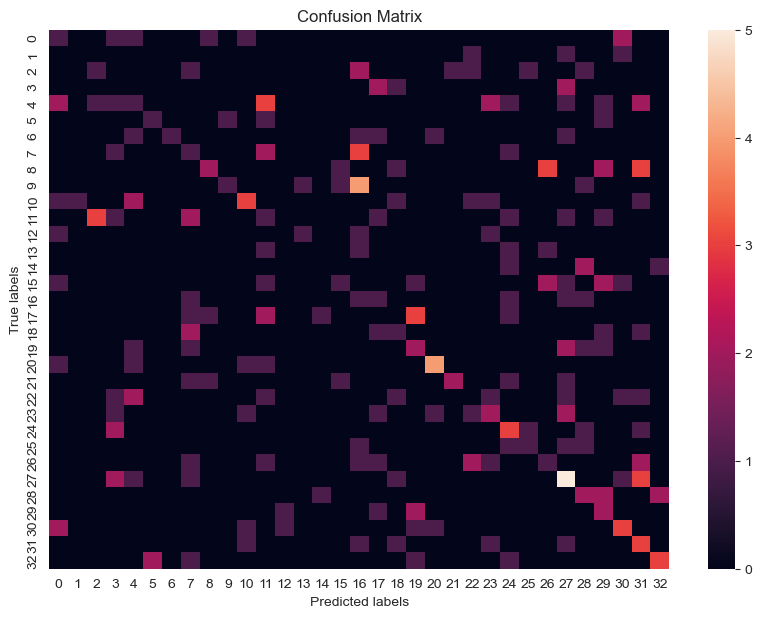

In [171]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [115]:
from sklearn.metrics import classification_report

class_labels = df['label'].unique()

print(classification_report(y_test_class, y_pred_class, target_names=class_labels))

              precision    recall  f1-score   support

          CH       0.50      0.50      0.50         2
          CZ       1.00      0.57      0.73         7
           Ł       1.00      0.83      0.91         6
           R       0.67      0.80      0.73         5
           U       1.00      0.62      0.76        13
           I       0.70      0.88      0.78         8
           N       0.78      0.78      0.78         9
           G       0.75      0.75      0.75         8
           Z       0.64      0.82      0.72        11
           T       0.86      0.75      0.80         8
          RZ       0.80      0.40      0.53        10
           S       0.33      0.50      0.40         2
           A       0.55      0.86      0.67         7
           Ó       0.25      0.25      0.25         4
           F       0.43      0.50      0.46         6
           O       0.38      0.62      0.48         8
           H       0.54      0.64      0.58        11
          SZ       0.40    